## Example of using TorchCNNBuilder for MovingMnist dataset

#### MovingMnist dataset is benchmark for video forecasting task. It is presented by 1000 samples with 20 frames series with numbers which are moving on different trajectories. It can be loaded by [official link](https://www.cs.toronto.edu/~nitish/unsupervised_video/).

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim, tensor
from torch.utils.data import TensorDataset, DataLoader
from torchcnnbuilder.models import ForecasterBase
from torch.optim.lr_scheduler import ReduceLROnPlateau

##### Data preparation include normalization and separating on train and test parts. As features (input) for model first 17 frames are used, as target (output) last 3 frames are used.

It should be noticed, that there is **not cyclic component** in each time-spatial series. So model should learn dynamics of numbers moving by examples from other series (on other numbers). And convolutional layers should help to reproduce view of number by previous frames of series. 

In [2]:
data = np.load('data/moving_mnist.npy').astype(np.float32)/255

train_set = data[:, :8000, :, :]
test_set = data[:, 8000:, :, :]

train_features = train_set[:17, :, :, :]
train_features = np.swapaxes(train_features, 0, 1)
train_target = train_set[17:, :, :, :]
train_target = np.swapaxes(train_target, 0, 1)

train_dataset = TensorDataset(tensor(train_features), tensor(train_target))

##### Model building with simple structure - 5 convolutional and 5 transposed convolutional layers. Resolution of images is 64x64 pixels and also specified

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Calculation on device: {device}')
model = ForecasterBase(input_size=[64, 64],
                       in_time_points=17,
                       out_time_points=3,
                       n_layers=5)
model = model.to(device)

cuda


##### Set parameters for training. The simple strategy without scheduler is presented. Epochs number and batch size can be changed depend on device and quality requirements.

In [4]:
epochs = 2000
batch_size = 100
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

##### Model training on 8000 samples. Loss values per epoch are saved for convergence visualization  


In [5]:
from tqdm.notebook import tqdm

progress_bar = tqdm(list(np.arange(epochs)), desc="Epoch", colour="white")
info_bar = {"Loss": 0}
losses = []
epoches = []
for epoch in range(epochs):
    loss = 0
    for train_features, train_targets in dataloader:
        train_features = train_features.to(device)
        train_targets = train_targets.to(device)

        optimizer.zero_grad()
        outputs = model(train_features)

        train_loss = criterion(outputs, train_targets)

        train_loss.backward()
        optimizer.step()

        loss += train_loss.item()

    loss = loss / len(dataloader)
    
    info_bar['Loss'] = np.round(loss, 5)
    progress_bar.update()
    progress_bar.set_postfix_str(info_bar)

    losses.append(loss)
    epoches.append(epoch)

torch.save(model.state_dict(), f'mnist_{epochs}.pt')

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

##### Loss value per epoch visualization. A gradual decrease in loss values indicates that the task has been set correctly.

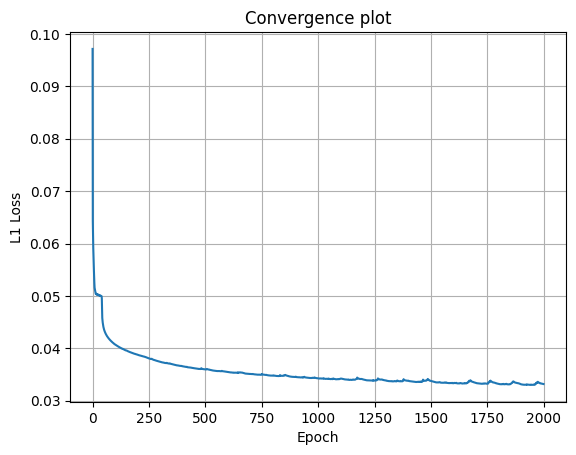

In [6]:
plt.plot(epoches, losses)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Convergence plot')
plt.show()

### Quality estimation on test set
##### *Loading features and target for test set* 

In [9]:
test_features = test_set[:17, :, :, :]
test_features = np.swapaxes(test_features, 0, 1)
test_target = test_set[17:, :, :, :]
test_target = np.swapaxes(test_target, 0, 1)
print('Data loaded')

Data loaded


##### *MAE (mean absolute error) calculation for each sample of test set*

In [23]:
l1_errors = []
for s in range(test_features.shape[0]):
    features = tensor(test_features[s]).to(device)
    prediction = model(features).detach().cpu().numpy()
    target = test_target[s]
    mae = np.mean(abs(prediction - target))
    l1_errors.append(mae)
print(f'Mean MAE for test set = {np.mean(l1_errors)}')  

Mean MAE for test set = 0.03650955110788345


##### Visualization of prediction results on test set (for first 5 samples) 

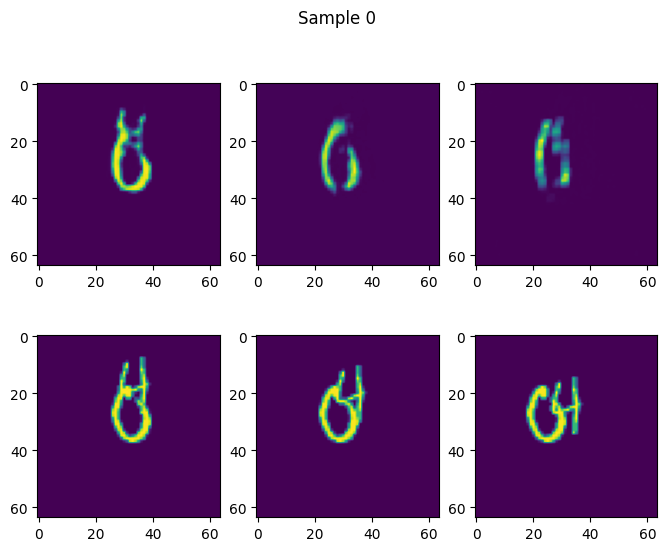

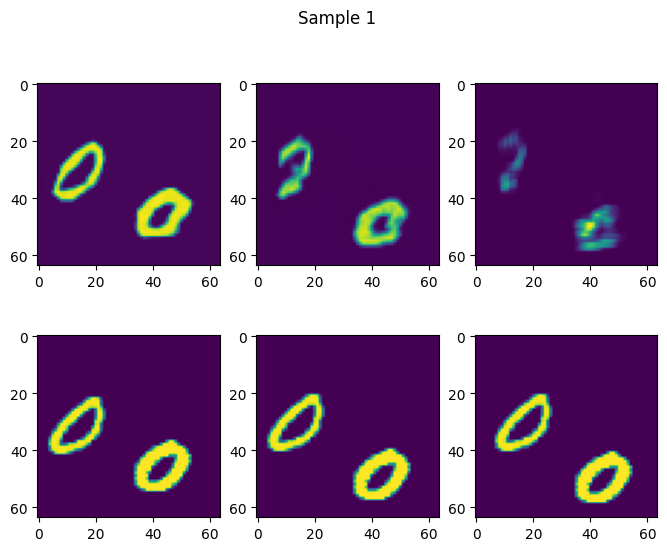

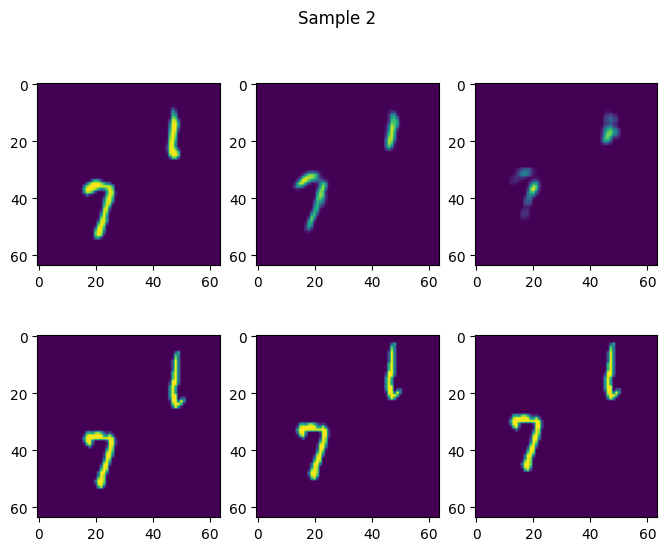

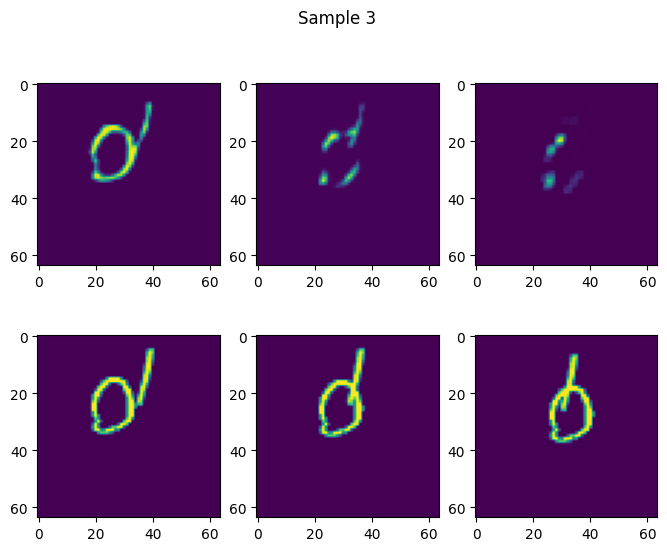

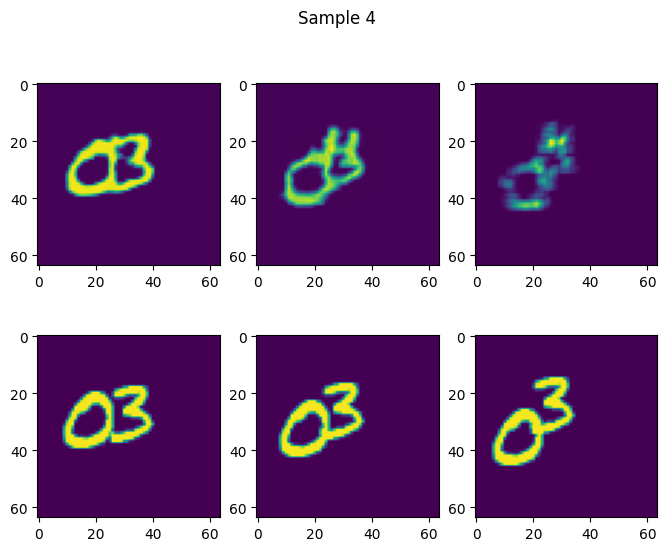

In [24]:
for s in range(5):
    tensor_features = tensor(test_features[s]).to(device)
    prediction = model(tensor_features).detach().cpu().numpy()
    plt.rcParams["figure.figsize"] = (8, 6)
    fig, axs = plt.subplots(2, 3)
    for i in range(3):
        axs[0][i].imshow(prediction[i])
        axs[1][i].imshow(test_target[s][i])
    plt.suptitle(f'Sample {s}')
    plt.show()

It can be concluded that the predictive ability of such a model with described training scheme is limited to 2 frames, despite the high quality metric. 